# COMP5138 Assignment 1 - Sem 2 2019

# Softmax Classifier 


## Source Data Input

This script assumes images_training.h5, labels_training.h5, images_testing.h5 and labels_testing_2000.h5 are in a child folder called 'Input' and that there is a child folder called 'Output' to generate the predicted label .h5 into.

In [210]:
import h5py
import numpy as np
import scipy as sp
import time
import pandas as pd


with h5py.File('./Input/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


## Pre-Processing

First we seperate 5000 records from the train data set to use as a validation set. We verify that the last 5000 records of the training set are a representative sample of the 10 classes in Fashion MNIST

In [211]:
unique, counts = np.unique(label_train[25000:,], return_counts=True)
print(dict(zip(unique, counts))) #display counts of classes in candidate validation set

#separate training and validation set 
data_val = data_train[25000:,]
data_partial_train = data_train[:25000,]

{0: 507, 1: 478, 2: 523, 3: 511, 4: 467, 5: 508, 6: 499, 7: 514, 8: 490, 9: 503}


Next we perform the same train/val split on the labels training set. We then one hot encode the labels vector, changing its shape from size (samples,) to (samples, classes). 

In [212]:
#one hot encode y for softmax output 
def oneHot(y):
    zeroesY = np.zeros((y.size, y.max() + 1)) #generate matrix of zeroes shape (samples, classes)
    zeroesY[np.arange(y.size), y] = 1 #insert value 1 at label y's scalar class value
    return zeroesY

label_val = oneHot(label_train[25000:,]) 
label_partial_train = oneHot(label_train[: 25000,])

print(data_partial_train.shape)

(25000, 784)


We then reshape the train and val data tensors of shape (samples,28,28) to matrices of shape (samples, 784)

In [213]:
print(data_partial_train.shape)


def pre_proc_mat(A, dims = 784):
    flat_A = A.reshape(A.shape[0],dims)
    return flat_A


data_partial_train = pre_proc_mat(data_partial_train)
data_val = pre_proc_mat(data_val)

print(data_partial_train.shape, data_val.shape)


(25000, 784)
(25000, 784) (5000, 784)


Following this we define the SVD fitting function. This takes in two parameters (data matrix, number of components), performs SVD decomposition and returns the right singular value V of shape (m,k), where m is the dimension of features and k is the choice of number of leading components from the SVD decomposition. When k < m dimension reduction has been performed:
$$
X_{n, m} V_{m, k}=U S V^{T} V=U_{n, k} S_{k, k}
$$
We perform this fitting procedure on the training set only (taking 150 components) and use the same V for the validation and test set.

In [214]:
def svd_fit(A, comps):   
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    #the matrix XV = UD therefore only need right singular value for decomposition
    V_tilde = Vt.T[:,0:comps] #create parameter to pick number of leading components to take from V
    return V_tilde

v = svd_fit(flat_data_partial_train, 150)

print(v.shape)

#take dot product of train and val set with V to perform dimension reduction
dim_partial_train = data_partial_train.dot(v)
dim_data_val = data_val.dot(v)

print( dim_partial_train.shape, dim_data_val.shape)

(784, 150)
(25000, 150) (5000, 150)


## Classifier 

We then move onto the building blocks of the softmax classifer. <br>
<br>
First we define the softmax function. it takes in the matrix X.W which has shape (samples,classes) and produces a matrix of shape (samples, classes) that sums to one per sample. 

In [215]:
def softmax(X): 
    eX = np.exp(X)
    A = eX / eX.sum(axis = 1, keepdims = True) #here we sum along classes per sample and broadcast this as the denominator
    return A

Next we define the loss function taking in the paramaters (data matrix X, one hot encoded labels y, weight matrix W, regulariser penalty l): 

$$
L(\boldsymbol{w}, l)=-\sum_{n} \sum_{k} y_{n k} \log \left(\sigma_{\boldsymbol{w}}(\boldsymbol{x})\right)+\frac{l}{2}\|\boldsymbol{w}\|_{2}^{2}
$$

Where sigma denotes the softmax transformation. The sum over all samples and all classes is captured in np.sum() over the matrix with shape (samples,classes)

In [216]:
#define softmax loss 
def softmax_loss(X, Y, W, l):
    A = softmax(X.dot(W))
    n = len(X)
    snorm = np.linalg.norm(W)**2
    return (-1/n) * np.sum(Y * np.log(A)) + (l/2)*snorm #np.sum over the matrix captures summing over both classes and samples

We define the direct gradient of the above loss function by creating a function that takes in the same paramaters:
$$
\frac{1}{n} \sum_{n}\left(\sigma_{w}\left(\boldsymbol{x}_{n}\right)-y_{n}\right) \boldsymbol{x}^{T}+l \boldsymbol{w}
$$

The output takes the shape (features, classes), preparing to be minused from the identical shaped weight vector W.
We slightly change the above formulation to compute the gradient over the whole data matrix with shape (samples, features). This requires a dot product with the matrix (A-Y) that has shape (samples, classes). 

In [217]:
#define softmax gradient 
def softmax_grad(X, Y, W, l):
    A = softmax(X.dot(W))  
    n = len(X) 
    return  (np.dot(X.T,(A - Y))/n) + l*W

With the softmax loss and gradients defined we can now define the fitting procedure. Here we employ batch gradient descent. This procedure involves choosing a randomly sampled without replacement batch size iteratively to perform gradient operations on. This value times a learning rate alpha is then minused from a weight vector. This procedure is then repeated over the dataset for a certain number of epochs. 

This function takes in a data matrix, the one hot encoded labels, a vector to optimise, a ridge penalty l, a number of epochs to optmise over and a number of batches per epoch. 

In [ ]:

def softmax_fit(X, Y, W, l, alpha, epoch,  batch):
    n = len(X) #sample size
    loss_hist = [softmax_loss(X, Y, W, l)] #generate intital loss history
    steps = int(np.ceil(n/batch)) #define the number of steps per epoch, determined by how many batches fit in the sample
    for ep in range(epoch): 
        p_ids = np.random.permutation(n) #generate a set of shuffled ids the size of the sample
        p_X = X[p_ids] #apply this shuffled id to data matrix
        p_Y = Y[p_ids] #apply this shuffled id to label matrix
        for i in range(steps): 
            # get the i-th batch
            X_batch = p_X[i:i + batch, :] #subset data matrix to size batch starting at step point i
            Y_batch = p_Y[i:i + batch] #perform same operation to label matrix
            W -=  alpha * softmax_grad(X_batch, Y_batch, W, l) #minus gradient for current w times learning rate from next w
        loss_hist.append(softmax_loss(X, Y, W, l)) #persist loss over runs
    return W, loss_hist

Having defined the softmax fitting algorithm we now generate initial values for the weight vector with shape (features, classes) and run the fitting algorithm on our chosen hyperparameters

In [ ]:
W_rand = np.random.randn(dim_partial_train.shape[1], len(label_partial_train[1]))
W, loss_hist = softmax_fit(dim_partial_train, 
                                      label_partial_train , 
                                      W_rand, 
                                      epoch = 1500, 
                                      batch = 1000,
                                      alpha = 0.1, 
                                      l = 0)

Now that we have trained the weight paramaters we can report the maximum probability from the softmax function to retrieve our model predictions. Accuracy is then assessed by summing where the condition for  predicted values and actual values is equivalent and dividing this by the total length of predictions

In [ ]:
#make predictions from softmax
def pred(W, X):
    A = softmax(X.dot(W))
    return np.argmax(A, axis = 1)

#accuracy
def accuracy(y_pred,y):
    results = pd.DataFrame({'label': y, 'answer': y == y_pred})
    return results['answer'].sum()/len(results)


In [ ]:
y_pre = pred(W,dim_data_val)
val_result = accuracy(y_pre,label_train[25000:,])
print(f'Validation set accuracy is {val_result}')

## Generate Test Result

The preprocessing step can then be repeated to generate predictions for the test set:

In [ ]:
with h5py.File('./Input/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

In [ ]:
print(data_test.shape)

#subset to labelled set
data_test_sub = data_test[:2000,:]

data_test_sub = pre_proc_mat(data_test_label)

dim_data_test_sub = data_test_sub.dot(v)

print(dim_data_test_sub.shape)

In [ ]:
test_result = accuracy(pred(W, dim_data_test_sub ), label_test)

print(f'Test set accuracy is {test_result}')

## Generate Full Test Prediction

In [ ]:
with h5py.File('./Input/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])
    
print(data_test.shape)

In [ ]:
data_test = pre_proc_mat(data_test)
print(data_test.shape)

dim_data_test = data_test.dot(v)

output = pred(W, dim_data_test)

output.shape

In [196]:
with h5py.File('./Output/predicted_labels.h5','w') as H:
    H.create_dataset('output',data=output)

# Decision Tree Classifier

### Source data input

In [202]:
import h5py
import numpy as np
import os
import scipy as sp
from math import sqrt
import pandas



with h5py.File('./Input/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
    
with h5py.File('./Input/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

print(data_train.shape,label_train.shape)
print(data_test.shape)

(30000, 784) (30000,)
(10000, 784)


### Check Source Data

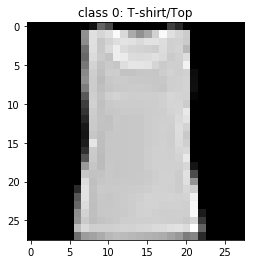

In [203]:
import matplotlib.pyplot as plt
data_train = data_train.reshape((data_train.shape[0], 28, 28))
data_test=data_test.reshape((data_test.shape[0], 28, 28))
plt.imshow(data_train[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[0]) + ": T-shirt/Top" )
plt.show()

### Date Pre-processing

As the values are continuous float, we need to bin the data, i.e. put the values into categories based on their value. We did this by multiplying all values by 10 and converting them into integers and as such we created 10 categories/bins labelled as 0 to 9. 

In [204]:
#convert the array value into int in order to bin the data
def Cover_to_int(array_x):
	x=np.multiply(array_x, 10)
	return x.astype(int)

#create val set
data_val = Cover_to_int(data_train[25000:30000,])
partial_train = Cover_to_int(data_train[:25000,])

#create val labels
label_val = label_train[25000:30000,].astype('int')
partial_label_train = label_train[:25000,].astype('int')


#create testing set
data_test=Cover_to_int(data_test[:2000])

print(data_val.shape)

(5000, 28, 28)


For data transformation,we use numpy.reduceat function to combine every 4 adjacent values on the matrix into 1 value by taking the their average

In [205]:
#reshape data
def reshape_matrix(x):
    x_1=np.add.reduceat(x,np.arange(0,28,2),1)
    x_2=np.add.reduceat(x_1,np.arange(0,28,2),2)
    x_3=x_2.reshape(x_2.shape[0],-1)
    x_v=np.multiply(x_3, 0.25).astype(int)
    return x_v

flat_partial_train = reshape_matrix(partial_train)
flat_data_val = reshape_matrix(data_val)
flat_data_test = reshape_matrix(data_test)

Check the date distribution between bins 

In [206]:
uniqueValues, Count = np.unique(flat_partial_train, return_counts=True)
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", Count)

Unique Values :  [ 0  1  2  3  4  5  6  7  8  9 10]
Occurrence Count :  [2484948  234889  247824  264361  274948  275550  315742  365818  359926
   75954      40]


As the count is classs 9 and 10 are significantly lower than other bins, they are combined into bin 9

In [207]:
flat_partial_train[flat_partial_train > 8] = 9

Combine training data with labels

In [208]:
#covert the matrix into 2 dimension
train_label_reshaped=partial_label_train.reshape(partial_label_train.shape[0],1)

#add the label data as the last feature to the train data
Train_data = np.hstack((flat_partial_train,train_label_reshaped))

#covert the matrix into 2 dimension
test_label_reshaped=label_val.reshape(label_val.shape[0],1)

#add the label data as the last feature to the train data
Test_data = np.hstack((flat_data_val,test_label_reshaped))

#covert the matrix into 2 dimension
access_label_reshaped=label_test.reshape(label_test.shape[0],1)

#add the label data as the last feature to the train data
Access_data = np.hstack((flat_data_test,access_label_reshaped))


### Decision Tree

In [24]:
# Split dataset according the the feature (ref) and criterion (value)
def data_split(ref, value, dataset):
	l, r = list(), list()   
    #check all rows in dataset
	for row in dataset:
        #if a value in the dataset is less then the criterion, put it to the left node, otherwise put it to the right node
		if row[ref] < value:
			l.append(row)
		else:
			r.append(row)
	return l, r
 
# Calculate the Gini index
def gini_index(DataSplit, classes):
	# count all samples at split point
	count_samples = float(sum([len(group) for group in DataSplit]))
	# sum weighted Gini ref for each group
	gini = 0.0
	for group in DataSplit:
        # calculate number of samples in the group
		size = float(len(group))
        # set initial score at 0
		score = 0.0
		# avoid divide by zero by giving it 0 score directly
		if size == 0:
			score = 0.0
		else:			        
            # score the group based on the score for each class
			for class_value in classes:
				class_sub=  [row[-1] for row in group]
                # calculate Proportion = number of classes / number of samples in the group
				p = class_sub.count(class_value) / size
				score += p **2
		# Gini index = [1-∑ (proportion * proportion)] * (group size/ dataset size)
		gini += (1.0 - score) * (size / count_samples)
	return gini
 
# Select the best split point for a dataset
def get_split(dataset):
	unique_class_val = list(set(row[-1] for row in dataset))
	b_score=9999
    # get the number of columns  
	n_feature = len(dataset[0])-1 
	for ref in range(n_feature):
        # get unique values in the column  
		unique_value=set([row[ref] for row in dataset])
		for criteria in unique_value:
            #skip the class 0 and 9 as they cannot split the dataset into two groups
			if criteria==0 or criteria==9:
				continue       
			DataSplit = data_split(ref, criteria, dataset)
			gini = gini_index(DataSplit, unique_class_val)
			if gini < b_score:
				b_ref = ref 
				b_value = criteria 
				b_score = gini 
				b_DataSplit = DataSplit
	return {'ref':b_ref, 'value':b_value, 'branch':b_DataSplit}
 
# Create a terminal node value
def terminal(group):
	result_class_val = [row[-1] for row in group]
    #use most common class value as the output for terminal node
	output=max(set(result_class_val), key=result_class_val.count)
	return output
 
# Create child-node and terminal node
def split(node, max_depth, min_leaf_size, depth):
	l, r = node['branch']
    #delete node as it is not needed
	del(node['branch'])
	len_l=len(l)
	len_r=len(r)	
	# if a split is a pure split, i.e. all value in a split belong to the same group. 
    # we wouldn’t be able to further split the data.
	if not l or not r:
		node['l'] = node['r'] = terminal(l + r)
		return
	# if it is over the max_depth, no further split required
	if depth >= max_depth:
		node['l'], node['r'] = terminal(l), terminal(r)
		return
	# if leave size less than min_leaf_size, no further split required
	if len_l <= min_leaf_size:      
		node['l'] = terminal(l)
	else:
        # if leave size is bigger than min_leaf_size, proceed with further split
		node['l'] = get_split(l)
		depth+=1
		split(node['l'], max_depth, min_leaf_size, depth)
	# if leave size less than min_leaf_size, no further split required
	if len_r <= min_leaf_size:
		node['r'] = terminal(r)
	else:
        # if leave size is bigger than min_leaf_size, proceed with further split
		node['r'] = get_split(r)
		depth+=1
		split(node['r'], max_depth, min_leaf_size, depth)
 
 # Call all functions needed to build the decision tree
def build_tree(train, max_depth, min_leaf_size):
	tree = get_split(train)
    # set initial depth as 1 as the split starting from root
	split(tree, max_depth, min_leaf_size, 1)
	return tree
 
# Predict with decision tree
def predict(tree, row):
    # tree has three components: ref, value, branch
    # the below code compares data value to criteria for split and determine if the left or right branch should be followed
	if row[tree['ref']] < tree['value']:
        # check if the a ternimal node is reached
		if isinstance(tree['l'], dict):
			return predict(tree['l'], row)
		else:
			return tree['l']
	else:
        # check if the a ternimal node is reached
		if isinstance(tree['r'], dict):
			return predict(tree['r'], row)
		else:
			return tree['r']

 
 # combin everything together
def decision_tree(train, test, max_depth, min_leaf_size):
	tree = build_tree(train, max_depth, min_leaf_size)
    # set prediction result as list
	predictions = list()
    # preform the prediction row by row
	for row in test:
		prediction = predict(tree, row)
		predictions.append(prediction)
	return(predictions)


### Predict with decision tree

In [25]:
pred = decision_tree(Train_data,Access_data,19,15)

### Access prediction accuracy

In [28]:
def accuracy(pred,y):
    Correct_count=0
    for i in range(0,len(pred)):
        if pred[i]==y[i]:
            Correct_count+=1 
    return Correct_count/len(y)

Pred_Accuracy = accuracy(pred,label_test)
print(Pred_Accuracy)

0.6085


### Access prediction accuracy

In [ ]:


def accuracy(pred,y):
    Correct_count=0
    for i in range(0,len(pred)):
        if pred[i]==y[i]:
            Correct_count+=1 
    return Correct_count/len(y)

Pred_Accuracy = accuracy(pred,label_test)
print(Pred_Accuracy)